In [78]:
from wordcount import nb_word_count 

filename = "MSIN0143_2020_GROUP_E2.ipynb"
nb_word_count(filename)

1998

# Report Structure:

1. Introduction
2. Data Preparation
3. Exploratory and Descriptive Analysis
4. Predictive Analysis
5. Limitations
6. Conclusion

# 1. Introduction

## Problem Statement

London housing is famously known for its extremely high price tag. Besides it being the capital, thereby contributing to house price, we would like to know what other influencing factors exist. Currently, there is no such platform/dataset offering transparent details on housing and related factors.

We aim to investigate how to gather insights from multiple datasets about the boroughs in London and how we can use predictive models to derive which factors are most important in influencing housing prices in London’s 33 boroughs.

With this project, we support the government in helping first-time home buyers find their ideal house, by increasing their understanding of trends in different Boroughs.

 


## Objective

Using historical data on house prices in London, we want to build a large dataset including various attributes influencing value and build a customisable search engine.

Based on our initial research, we have gathered a shortlist of variables that may contribute towards housing prices (Mason, 2017). We will then research the relevant dataset at Borough level to compile our dataset.

Our goal is to create a model transparently predicting house prices in different boroughs, whilst controlling for certain area characteristics and time. Different factors that influence the price shall be taken into consideration and analysed with regards to their influence on price. 


In [1]:
#Import necessary modules and codes
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import faculty.datasets as datasets
import pandas as pd
from pandas import DataFrame
from functools import reduce
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
import math 
import seaborn as sn
from functools import reduce
from scipy.stats import skew
from sklearn import linear_model
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import PooledOLS
from linearmodels.panel import compare
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression,LogisticRegression, SGDRegressor, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import sklearn.model_selection
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import preprocessing

ModuleNotFoundError: No module named 'linearmodels'

# 2. Data Preparation

This report will be based on 9 different datasets.


<img src="./Variable Name.JPG" width="100%" align="centre">


Datasets 1 to 7 contain information on each of London's 33 boroughs for a variable of interest, across different time periods. Whereas datasets 8 and 9 contain information on a variable of interest at one single point in time.

    
Upon completion of prepping the 9 datasets, 3 seperate merges will carried out:

1. Panel Data Merge - Datasets 1 to 7 will be merged on the Area Code and Year Column
2. First Year Data Merge (2011) - Datasets 1 to 7 with 8 and 9 will be merged on the Area Code Column
3. Last Year Data Merge (2017) - Datasets 1 to 7 with , 8 and 9 will be merged on the Area Code Column

All 3 merged datasets will be used for Exploratory and Descriptive Analysis, and the merged panel dataset will be used for Predictive Analysis.


## Data Prep

## Dataset

Source of main dataset (Housing in London):

https://www.kaggle.com/justinas/housing-in-london?select=housing_in_london_yearly_variables.csv

### House Prices
- Source - **Kaggle** 
- Variable of Interest - **House Prices**

In [2]:
# Importing the House Price Dataset
house_price_df= pd.read_csv("01. Monthly House Price Data.csv",usecols=[0,1,2,3])
house_price_df=house_price_df.sort_values(by=["date","code"])
house_price_df["date"]=house_price_df["date"].astype(str)

# Filtering for relevant years (2011 to 2017)
house_price_df=house_price_df[8644:12424]

# Calculating the yearly average price
house_price_df["year"]=house_price_df["date"].str[0:4]
house_price_df=house_price_df.groupby(["code","area","year"]).mean()
house_price_df["average_price"]=house_price_df["average_price"].astype(int)

# Filtering for relevant area codes (London Borough Codes)
house_price_df=house_price_df.sort_values(by=["code","year"])
house_price_df=house_price_df[:231]

# Renaming and coverting column types in preparation of merge
house_price_df=house_price_df.reset_index(inplace=False)
house_price_df = house_price_df.rename(columns={'area': 'Area','code': 'Code',
                                                'year': "Year",'average_price': 'House Price'})
house_price_df["Year"]=house_price_df["Year"].astype(int)

In [3]:
# Checking first 5 rows of dataset
house_price_df.head()

,Code,Area,Year,House Price
0,E09000001,city of london,2011,463930
1,E09000001,city of london,2012,525327
2,E09000001,city of london,2013,570008
3,E09000001,city of london,2014,709385
4,E09000001,city of london,2015,760253


### Crime
- Source - **Metropolitan Police** 
- Variable of Interest - **Recorded Offences**

In [4]:
# Importing the Crime dataset
crime_df = pd.read_excel('01 New Crime data .xlsx',
                            usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
                            header = 1, 
                            index_col=0, 
                            sheet_name="Crime Rates")

# Dropping NAs and irrelevant columns
crime_df = crime_df.dropna()
crime_df = crime_df.drop(labels = ['Borough','1999-00','2000-01','2001-02','2002-03','2003-04','2004-05',
                                         '2005-06','2006-07','2007-08','2008-09','2009-10','2010-11'],axis = 1)

# Renaming the columns name and dropping irrelevant areas (Codes outside of London)
crime_df = crime_df.rename(index=str,columns={'2011-12':'2011','2012-13':'2012','2013-14':'2013'
                           ,'2014-15':'2014','2015-16':'2015','2016-17':'2016','2017-18':'2017'})
crime_df = crime_df.drop(['E12000007','E13000001','E13000002'],axis = 0)
crime_df = crime_df.sort_values(by='Code')

# Converting table into panel data format
crime_2011 = crime_df["2011"]
crime_2012 = crime_df["2012"]
crime_2013 = crime_df["2013"]
crime_2014 = crime_df["2014"] 
crime_2015 = crime_df["2015"]
crime_2016 = crime_df["2016"]
crime_2017 = crime_df["2017"]
crime_df2 = pd.concat([crime_2011,crime_2012,crime_2013,crime_2014,crime_2015,crime_2016,crime_2017]
                       ,axis = 0)
crime_df2 = pd.DataFrame(crime_df2,columns = ['Crime Rates'])

# Creating lists of Borough Codes and Years for crime_df2 
codes = []
for i in crime_df.columns:
    for j in range(33):
        codes.append(i)
years = []        
for j in range(7):
    for i in crime_df.index:
        years.append(i)        

# Adding Borough codes to Borough Codes to crime_df2
years_df = pd.DataFrame(codes,columns = ['Year'],index = years)
crime_df2 = pd.concat([years_df,crime_df2],axis = 1)
crime_df2 = crime_df2.sort_values(by = ['Code','Year'])

# Resetting the index and converting year values in preperation of merge
crime_df2.reset_index(inplace=True)
crime_df2["Year"] = crime_df2["Year"].astype(int)

In [5]:
# Checking first 5 rows of dataset
crime_df2.head()

,Code,Year,Crime Rates
0,E09000001,2011,90.6
1,E09000001,2012,85.8
2,E09000001,2013,77.9
3,E09000001,2014,85.5
4,E09000001,2015,82.4


###  Education
- Source - **London Datastore** 
- Variable of Interest - **Schools**

In [6]:
# Each years data is held on a different worksheet in the excel file
# Defining functions that will automatically clean a worksheet
# For years 2011-2015
def education_cleaning1(year):
    education_df = pd.read_excel("01. Education Data.xls", header=1, 
                                 usecols=[0,1,18],
                                 skiprows=[2,3,4,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54],
                                 sheet_name=year)  
    education_df = education_df.dropna()
    education_df = education_df.rename(columns={'All schools': 'Schools'})
    education_df["Schools"]=education_df["Schools"].astype(int) # change from float to int
    education_df.insert(2,"Year",year)
    return education_df
 
# Function for years 2016-2017, as "total" are in different columns in dataset
def education_cleaning2(year):
    education_df = pd.read_excel("01. Education Data.xls", header=1, 
                             usecols=[0,1,16],
                             skiprows=[2,3,4,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54],
                             sheet_name=year)  
    education_df = education_df.dropna()
    education_df = education_df.rename(columns={'All schools': 'Schools'})
    education_df["Schools"]=education_df["Schools"].astype(int)
    education_df.insert(2,"Year",year)
    return education_df

# Grouping all the dataframes together
edu_2011 = education_cleaning1("2011")
edu_2012 = education_cleaning1("2012")
edu_2013 = education_cleaning1("2013")
edu_2014 = education_cleaning1("2014") 
edu_2015 = education_cleaning1("2015")
edu_2016 = education_cleaning2("2016")
edu_2017 = education_cleaning2("2017")

edu_dataset = [edu_2011, edu_2012, edu_2013, edu_2014,edu_2015,edu_2016,
               edu_2017]
edu_df = pd.concat(edu_dataset)

# Transforming dataframe into panel data format by ordering and renaming columns
edu_df = edu_df.sort_values(by=["LA Code","Year"])
edu_df=edu_df.rename(columns={"LA Code": 'Code'})

# Converting year values and keeping relevant columns in preperation of merge
edu_df["Year"]=edu_df["Year"].astype(int)
edu_df = edu_df[["Code", "Year", "Schools"]]

In [7]:
# Checking first 5 rows of dataset
edu_df.head()

,Code,Year,Schools
0,E09000001,2011,5
0,E09000001,2012,5
0,E09000001,2013,5
0,E09000001,2014,5
0,E09000001,2015,5


### Employment Opportunity
- Source - **London Datastore** 
- Variable of Interest - **Job Density**

In [8]:
# Importing the Employment Opportunity Dataset
employment_opps_df = pd.read_excel("01. Employment Opportuntiy Data.xlsx", index_col=0, sheet_name="Jobs Density")      

# Dropping NAs, irrelevant areas (Codes outside of London) and years
employment_opps_df = employment_opps_df.dropna()
employment_opps_df = employment_opps_df[0:33]
employment_opps_df = employment_opps_df[[2011,2012,2013, 2014, 2015, 2016, 2017]]

# Converting the dataframe into panel data format
employment_df = employment_opps_df.stack()
employment_df = pd.DataFrame(employment_df)

# Renaming the Years and Job Density Columns
employment_df = employment_df.reset_index()
employment_df.rename(index=str, columns={"level_1": "Year", 0: "Job Density"}, inplace = True)

In [9]:
# Checking first 5 rows of dataset
employment_df.head()

,Code,Year,Job Density
0,E09000001,2011,75.79
1,E09000001,2012,92.41
2,E09000001,2013,110.98
3,E09000001,2014,121.23
4,E09000001,2015,121.73


### Wages
- Source - **London Datastore** 
- Variable of Interest - **Full-Time Annual Salary**

In [10]:
# Importing the Wages, Area Codes dataset
wages_df = pd.read_excel("01. Wage Dataset.xlsx", index_col=0, sheet_name="Full-time, Weekly")
area_codes_df = pd.read_csv("01. Area Codes.csv")

# Removing NAs and filtering for relevant areas
wages_df = wages_df.dropna()
wages_df = wages_df[0:33]

# Merging Wages and London Area Codes Dataset (this adds the area codes for each borough)
wages_df = wages_df.rename(columns={"Area": "Borough"})
m_wages_df = pd.merge(wages_df, area_codes_df, on = 'Borough')
m_wages_df = m_wages_df.drop(["Borough"], axis = 1)

#Select the year ranging from 2011 to 2017, whilst dropping any duplicated row
m_wages_df = m_wages_df[["Area Code",2011,2012,2013, 2014, 2015, 2016, 2017]]
m_wages_df = m_wages_df.set_index("Area Code")
m_wages_df = m_wages_df.drop_duplicates()
m_wages_df = m_wages_df.replace("#",0)

#Since we used the weekly wage sheet, to get the annual salary we times weekly wages by 52
m_wages_df[[2011,2012,2013, 2014, 2015, 2016, 2017]] = m_wages_df[[2011,2012,2013, 2014, 2015, 2016, 2017]]*52
f_wages_df = m_wages_df[[2011,2012,2013, 2014, 2015, 2016, 2017]]

#using the stack function we will transform the dataframe into a panel data 
f_wages_df = f_wages_df.stack()
f_wages_df = f_wages_df.reset_index()
f_wages_df.rename(index=str, columns={"Area Code": "Code","level_1": "Year", 0: "Annual Salary"}, inplace = True)

In [11]:
# Checking first 5 rows of dataset
f_wages_df.head()

,Code,Year,Annual Salary
0,E09000001,2011,52358.800000
1,E09000001,2012,52379.993605
2,E09000001,2013,55510.309047
3,E09000001,2014,55514.808380
4,E09000001,2015,55889.369644


###  Leisure & Entertainment
- Source - **London Datastore** 
- Variable of Interest - **Number of Pubs and Restaurants**

In [12]:
#importing the pubs (p) and restaurants (r) datasets
leisure_p_df = pd.read_excel("01. Leisure & Entertainment Data (Pubs).xls", sheet_name="Pubs units", header = 3, skiprows = [4,5]) 
leisure_r_df = pd.read_excel("01. Leisure & Entertainment Data (Restaurants).xls", sheet_name="Restaurants units", header = 3,skiprows = [4,5]) 

# Dropping NAs
leisure_p_df = leisure_p_df.dropna()
leisure_r_df = leisure_r_df.dropna()

# Renaming columns manually
leisure_p_df = leisure_p_df.rename(columns={"Unnamed: 0":"Area Code", "Unnamed: 1": "Area Name"})
leisure_p_df = leisure_p_df.set_index("Area Code")
leisure_r_df = leisure_r_df.rename(columns={"Unnamed: 0":"Area Code","Unnamed: 1": "Area Name"})
leisure_r_df = leisure_r_df.set_index("Area Code")

# Excluding years outside of 2011 - 2017
leisure_p_df_selected = leisure_p_df[[2011, 2012,2013,2014,2015,2016,2017]]
leisure_r_df_selected = leisure_r_df[[2011, 2012,2013,2014,2015,2016,2017]]

# Converting to panel data format
panel_leisure_p_df_selected = leisure_p_df_selected.stack()
panel_leisure_p_df_selected = pd.DataFrame(panel_leisure_p_df_selected)
panel_leisure_r_df_selected = leisure_r_df_selected.stack()
panel_leisure_r_df_selected = pd.DataFrame(panel_leisure_r_df_selected)

# Renaming columns years and No. of Pubs/Restaurants
panel_leisure_p_df_selected = panel_leisure_p_df_selected.reset_index()
panel_leisure_p_df_selected.rename(index=str, columns={"level_1": "Year", 0: "Number of Facilities"}, inplace = True)
panel_leisure_r_df_selected = panel_leisure_r_df_selected.reset_index()
panel_leisure_r_df_selected.rename(index=str, columns={"level_1": "Year", 0: "Number of Facilities"}, inplace = True)

# Merging Pubs and Restaurants into one Dataframe
leisure_df = pd.merge(panel_leisure_p_df_selected, panel_leisure_r_df_selected, left_index=True, right_index=True, how='outer')
leisure_df = leisure_df.drop(['Area Code_y', 'Year_y'], axis=1)
leisure_df = leisure_df.rename(index=str, columns={"Area Code_x":"Area Code", "Year_x": "Year", "Number of Facilities_x": "Number of Pubs","Number of Facilities_y":"Number of Restaurants"})

# Combining Bars and Restuarants Values and renaming Area Code Column in preparation of merge
leisure_df["Bars and Restaurants"] = leisure_df['Number of Pubs'] + leisure_df['Number of Restaurants']
leisure_df = leisure_df.drop(['Number of Restaurants', 'Number of Pubs'], axis=1)
leisure_df = leisure_df.rename(columns={"Area Code":"Code"})

In [13]:
# Checking first 5 rows of dataset
leisure_df.head()

,Code,Year,Bars and Restaurants
0,E09000001,2011,365.0
1,E09000001,2012,370.0
2,E09000001,2013,385.0
3,E09000001,2014,415.0
4,E09000001,2015,420.0


### Healthcare
- Source - **NHS** 
- Variable of Interest - **Number of GP Practices**

In [14]:
# Importing the healthcare, mappings and area codes datasets
healthcare_df = pd.read_csv("01. Healthcare Data.csv", names=["Practice Name", "Postcode"], usecols= [1, 9])
mappings_df = pd.read_csv('01. Postcodes to Borough Mappings.csv', usecols=[0,8])
area_codes_df = pd.read_csv("01. Area Codes.csv")

# Dropping NAs from dataset
healthcare_df = healthcare_df.dropna()

# Merging Healthcare and Mappings Dataset
mappings_df = mappings_df.rename(columns = {"District": "Borough"})
m_healthcare_df = pd.merge(healthcare_df, mappings_df,on = ['Postcode'],how = 'inner')
m_healthcare_df = m_healthcare_df[["Practice Name", "Borough"]]

# Aggregating Dataframe by the number of Practices per Borough
m_healthcare_df = m_healthcare_df['Borough'].value_counts().rename_axis('Borough').reset_index(name='Healthcare Practices')

# Merging Healthcare and London Area Codes Dataset (this drops practices out of London)
f_healthcare_df = pd.merge(m_healthcare_df, area_codes_df, on="Borough")
f_healthcare_df = f_healthcare_df.set_index("Area Code").sort_values("Area Code")

# Resetting index, renaming and dropping unneeded columns in preparation of merge
f_healthcare_df=f_healthcare_df.reset_index(inplace=False)
f_healthcare_df.rename(columns={"Area Code":"Code"}, inplace = True)
f_healthcare_df=f_healthcare_df.drop(columns="Borough")

In [15]:
# Checking first 5 rows of dataset
f_healthcare_df.head()

,Code,Healthcare Practices
0,E09000001,2
1,E09000002,65
2,E09000003,98
3,E09000004,46
4,E09000005,95


### Transport
- Source - **Doogal** 
- Variable of Interest - **Number of TfL Transport Stations and Average of TfL Transport Zones (in Borough)**

In [16]:
# Importing the transport, mappings and area codes datasets
transport_df = pd.read_csv("01. Transport Data.csv")
mappings_df = pd.read_csv('01. Postcodes to Borough Mappings.csv', usecols=[0,8])
area_codes_df = pd.read_csv("01. Area Codes.csv")

# Dropping NAs and keeping columns of interest
transport_df = transport_df[["Station", "Zone", "Postcode"]]
transport_df = transport_df.dropna()

# Creating a Zone Column representing the most central transport zone
zones = transport_df["Zone"].str.split(",", expand = True)
transport_df["Zone"] = zones[0]

# Merging Transport and Mappings Datasets
mappings_df = mappings_df.rename(columns = {"District": "Borough"})
m_transport_df = pd.merge(transport_df, mappings_df,on = ['Postcode'],how = 'inner')
m_transport_df = m_transport_df[["Station", "Zone", "Borough"]]

# Aggregating Dataframe by the number of Stations per Borough
f_transport_df = m_transport_df['Borough'].value_counts().rename_axis('Borough').reset_index(name='Transport Stations')

# Creating a Zones dataset with a mean transport zone for each borough
zones_df = m_transport_df[["Zone", "Borough"]].set_index('Borough')
zones_df["Zone"] = zones_df["Zone"].astype(int)
zones_df = zones_df.mean(level="Borough")

# Merging the merged transport dataset with Zones dataset
f_transport_df = pd.merge(f_transport_df, zones_df, on = ['Borough'])
f_transport_df.rename(columns={'Zone': 'Average of Transport Zones'}, inplace = True)

# Merging Transport and London Area Codes Dataset (this drops practices out of London)
f_transport_df = pd.merge(f_transport_df, area_codes_df, on="Borough")
f_transport_df = f_transport_df.set_index("Area Code").sort_values("Area Code")

# Resetting index, renaming and dropping unneeded columns in preparation of merge
f_transport_df = f_transport_df.reset_index(inplace=False)
f_transport_df.rename(columns={"Area Code":"Code"}, inplace = True)
f_transport_df = f_transport_df.drop(columns="Borough")

In [17]:
# Checking first 5 rows of dataset
f_transport_df.head()

,Code,Transport Stations,Average of Transport Zones
0,E09000001,13,1.000000
1,E09000002,7,4.714286
2,E09000003,18,3.833333
3,E09000004,12,5.166667
4,E09000005,27,3.148148


## Data Merge

### Panel Data

In [18]:
# Merging the indidviual panel dataframes
sources_df = [house_price_df, crime_df2, edu_df, employment_df, f_wages_df, leisure_df]

final_dataset = reduce(lambda  left, right: pd.merge(left,right,on=("Code","Year"),
                                            how='inner'), sources_df)

# Capitalising Area Column
final_dataset["Area"] = final_dataset["Area"].apply(lambda x: x.upper())

In [19]:
# Checking first 5 rows of dataset
final_dataset.head()

,Code,Area,Year,House Price,Crime Rates,Schools,Job Density,Annual Salary,Bars and Restaurants
0,E09000001,CITY OF LONDON,2011,463930,90.6,5,75.79,52358.800000,365.0
1,E09000001,CITY OF LONDON,2012,525327,85.8,5,92.41,52379.993605,370.0
2,E09000001,CITY OF LONDON,2013,570008,77.9,5,110.98,55510.309047,385.0
3,E09000001,CITY OF LONDON,2014,709385,85.5,5,121.23,55514.808380,415.0
4,E09000001,CITY OF LONDON,2015,760253,82.4,5,121.73,55889.369644,420.0


### First Year Data

In [20]:
# Filtering Final Dataset for the first year (2011)
firstyr_dataset = final_dataset[final_dataset["Year"]==2011].drop(columns="Year")

# Merging Filtered Final Dataset with Transport and Healthcare Dataset
firstyr_dataset = pd.merge(firstyr_dataset, f_healthcare_df,on=("Code"))
firstyr_dataset = pd.merge(firstyr_dataset, f_transport_df,on=("Code"))

In [21]:
# Checking first 5 rows of dataset
firstyr_dataset.head()

,Code,Area,House Price,Crime Rates,Schools,Job Density,Annual Salary,Bars and Restaurants,Healthcare Practices,Transport Stations,Average of Transport Zones
0,E09000001,CITY OF LONDON,463930,90.600000,5,75.79,52358.8,365.0,2,13,1.000000
1,E09000002,BARKING AND DAGENHAM,163465,100.652840,59,0.45,26041.6,55.0,65,7,4.714286
2,E09000003,BARNET,338978,73.505474,154,0.62,32312.8,300.0,98,18,3.833333
3,E09000004,BEXLEY,200672,52.273879,83,0.53,31668.0,190.0,46,12,5.166667
4,E09000005,BRENT,298964,101.176960,103,0.53,25911.6,250.0,95,27,3.148148


### Last Year Data

In [22]:
# Filtering Final Dataset for the last year (2017)
lastyr_dataset = final_dataset[final_dataset["Year"]==2017].drop(columns="Year")

# Merging Filtered Final Dataset with Transport and Healthcare Dataset
lastyr_dataset = pd.merge(lastyr_dataset, f_healthcare_df,on=("Code"))
lastyr_dataset = pd.merge(lastyr_dataset, f_transport_df,on=("Code"))

In [23]:
# Checking first 5 rows of dataset
lastyr_dataset.head()

,Code,Area,House Price,Crime Rates,Schools,Job Density,Annual Salary,Bars and Restaurants,Healthcare Practices,Transport Stations,Average of Transport Zones
0,E09000001,CITY OF LONDON,849790,92.200000,5,124.78,57328.122094,455.0,2,13,1.000000
1,E09000002,BARKING AND DAGENHAM,287734,78.794325,64,0.49,28906.800000,55.0,65,7,4.714286
2,E09000003,BARNET,538280,54.429232,161,0.70,35880.000000,350.0,98,18,3.833333
3,E09000004,BEXLEY,335694,39.765179,84,0.59,32479.200000,205.0,46,12,5.166667
4,E09000005,BRENT,487703,69.910019,98,0.71,29302.000000,260.0,95,27,3.148148


# 3.  Descriptive and Exploratory Analysis

### Data type and Borough

Here, we introduce the datatypes of all variables and list all boroughs in London.

In [24]:
final_dataset.dtypes

Code                     object
Area                     object
Year                      int64
House Price               int64
Crime Rates             float64
Schools                   int64
Job Density             float64
Annual Salary           float64
Bars and Restaurants    float64
dtype: object

In [25]:
table_borough = final_dataset[["Code","Area"]].drop_duplicates()
table_borough.set_index("Code")

,Area
Code,
E09000001,CITY OF LONDON
E09000002,BARKING AND DAGENHAM
E09000003,BARNET
E09000004,BEXLEY
E09000005,BRENT
E09000006,BROMLEY
E09000007,CAMDEN
E09000008,CROYDON
E09000009,EALING


## Statistical Description of Data

We create a summary statistics table for our dataset:

In [26]:
descriptive_table = final_dataset.describe()
descriptive_table

,Year,House Price,Crime Rates,Schools,Job Density,Annual Salary,Bars and Restaurants
count,231.000000,2.310000e+02,231.000000,231.000000,231.000000,231.000000,231.000000
mean,2014.000000,4.357631e+05,84.779510,93.536797,4.194805,33529.633135,326.645022
std,2.004343,2.126523e+05,34.024164,26.678557,18.972746,5366.229929,270.522240
min,2011.000000,1.634650e+05,39.765179,5.000000,0.390000,25906.400000,55.000000
25%,2012.000000,2.979545e+05,64.265730,78.500000,0.540000,30209.400000,187.500000
50%,2014.000000,3.769240e+05,77.847006,96.000000,0.650000,32219.200000,255.000000
75%,2016.000000,5.035330e+05,96.723957,108.000000,1.100000,35648.600000,370.000000
max,2017.000000,1.344539e+06,302.005629,164.000000,124.780000,57328.122094,1700.000000


We have 231 observations. 
Now we provide a snapshot of 2017’s summary statistics:

In [27]:
#Using describe to generate mean for all the variable in 2011 and create a Dataframe 
last = lastyr_dataset.describe()
lastyr_describe = pd.DataFrame(last)

#Using describe to generate mean for all the variable in 2017 and create a Dataframe 
first = firstyr_dataset.describe()
firstyr_describe = pd.DataFrame(first)

#using the following formula we can generate the percentage different over the 6 years.
ptc_df = round(((lastyr_describe - firstyr_describe)/(firstyr_describe))*100,2)
#Dropping any non-relevant variable, since Healthcare Practice, Transport station and average transport zone didn't change between 2011 and 2017. 
ptc_df = ptc_df.drop(["Healthcare Practices", "Transport Stations", "Average of Transport Zones"], axis = 1)
#Dropping other non-relevant rows provided by the describe function
ptc_df = ptc_df[1:2]
#Adding percentage sign onto the values 
ptc_df.astype(str).add("%").T

,mean
House Price,62.59%
Crime Rates,-28.21%
Schools,4.14%
Job Density,51.12%
Annual Salary,7.3%
Bars and Restaurants,15.27%


Next, we vissualize the percentage change in summary statistics from 2011 to 2017. 

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

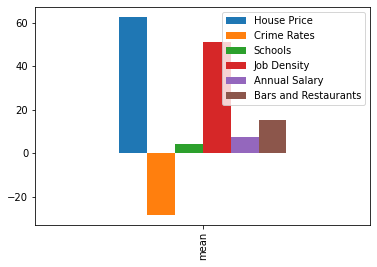

In [28]:
%matplotlib inline
plt.figure(figsize=(16, 8))
ptc_df.plot.bar()

##  Exploratory Analysis 


##  Dependent Variable - House Price

We will now review house prices in detail, as it is  our dependent variable in Section 4.


### House Price Heatmap

In [3]:
%%HTML 
# we didn't run the output because it cannot show correctly in PDF. However we took a screenshot to show what does it looks like. People can run it on faculty.
<div class='tableauPlaceholder' id='viz1607777849491' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;SM&#47;SMX2P7QYY&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='shared&#47;SMX2P7QYY' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;SM&#47;SMX2P7QYY&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1607777849491');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

<img src="./Heatmap.JPG" width="100%" align="centre">

### Annual Salary and House Price Plot

Given high property prices in London, we compare the percentage change in Londoners’ salaries and house prices.

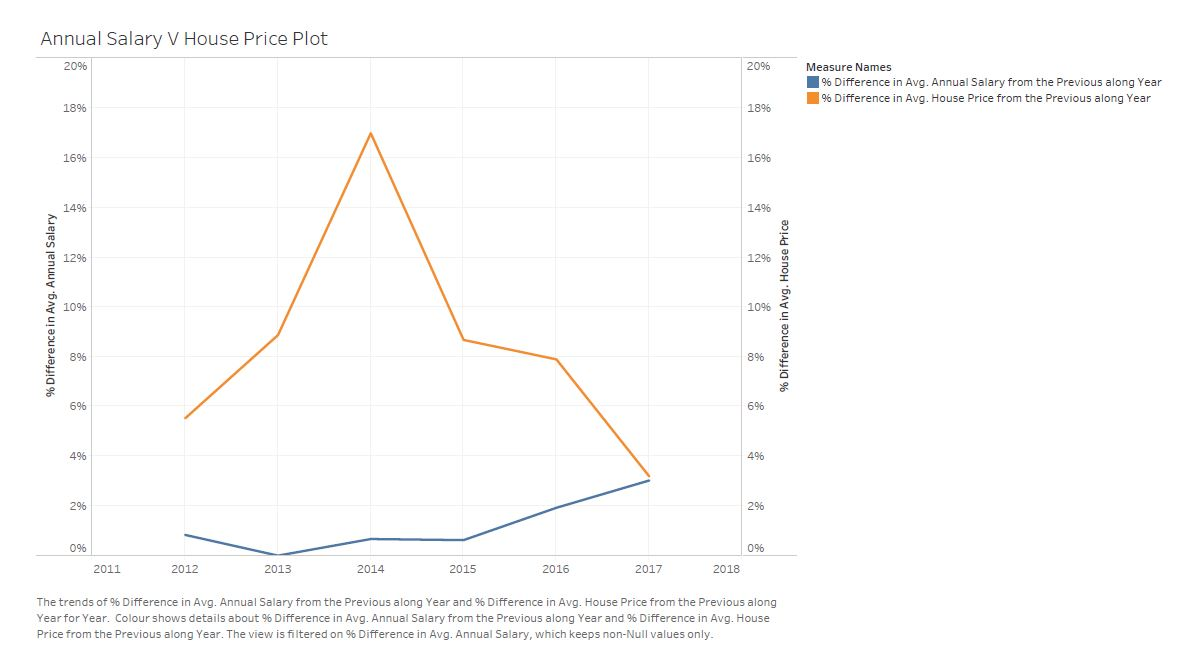

Between 2013 and 2014, the percentage change in house prices increased by 8.11%, attributed to record low interest rates, driving up demand (Osborne, 2014). However, from 2016 to 2017 the percentage change in  prices decreased by 3.19%, as uncertainty over Brexit take effect (Collinson, 2017). 


London's problem of affordability is visualised above, by the disproportionate increases in house prices relative to annual salary. New home buyers face challenging times ahead.

### Histogram

<Figure size 1152x576 with 0 Axes>

(array([ 7., 12.,  6.,  3.,  1.,  2.,  0.,  1.,  0.,  1.]),
 array([ 287734. ,  393414.5,  499095. ,  604775.5,  710456. ,  816136.5,
         921817. , 1027497.5, 1133178. , 1238858.5, 1344539. ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, "London Boroughs' Average House Prices in 2017")

([<matplotlib.axis.XTick at 0x7f058a3e5130>,
 [Text(0, 0, '287'),
  Text(0, 0, '393'),
  Text(0, 0, '499'),
  Text(0, 0, '604'),
  Text(0, 0, '710'),
  Text(0, 0, '816'),
  Text(0, 0, '921'),
  Text(0, 0, '1027'),
  Text(0, 0, '1133'),
  Text(0, 0, '1238'),
  Text(0, 0, '1344')])

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 <a list of 8 Text major ticklabel objects>)

Text(0.5, 0, 'Average House Price (£000s)')

Text(0, 0.5, 'Count of Boroughs')

Text(1180000, 11.5, 'Skew = 1.99')

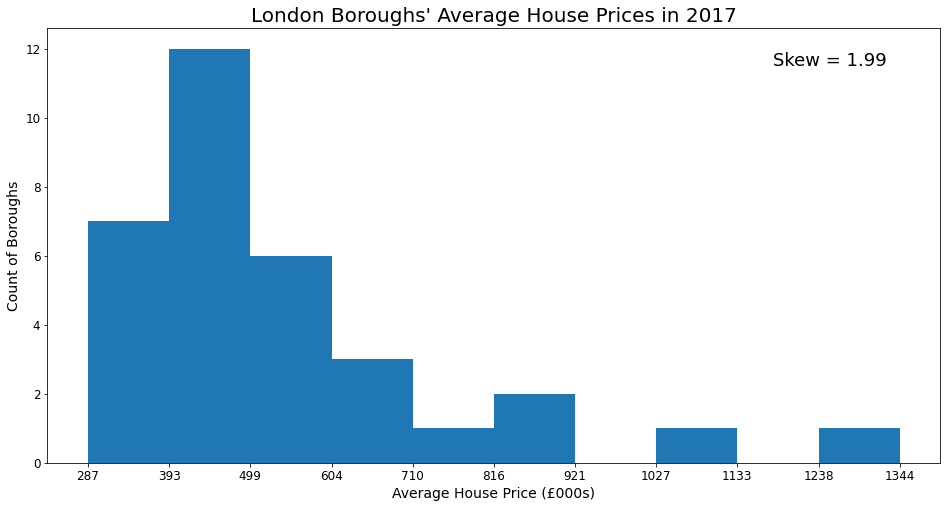

In [29]:
#Selecting House Price to be plotted on the histogram
house_price =lastyr_dataset["House Price"]

# Creating a histogram based on 10 bins
hist, bin_edges = np.histogram(house_price)

# Dividing bin edges by 1000 and rounding for ease of reading on histogram
tick_labels = bin_edges/1000
tick_labels = [int(label) for label in tick_labels]

# Calculating the skewness of the histogram
skew_value = round(skew(house_price), 2)
skew_text = "Skew = " + str(skew_value)

# Plotting the histogram and adding text on it's skewness

plt.figure(figsize=(16, 8))
plt.hist(house_price, bins=10)
plt.title("London Boroughs' Average House Prices in 2017", fontsize = 20)
plt.xticks(bin_edges, tick_labels, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Average House Price (£000s)", fontsize = 14)
plt.ylabel("Count of Boroughs", fontsize = 14)
plt.text(1180000, 11.5, skew_text, fontsize = 18)
plt.show()

The House Prices histogram illustrates a positively skewed distribution, indicating that many boroughs  average house prices are below London’s total mean. This is an indication of London’s high upper bound of house prices.

## Independent Variables

## Seaborn Heatmap

In [30]:
%%capture
# Creating a Seaborn Heatmap visualising the Density of Schools per Borough
last = lastyr_dataset
last_df = pd.DataFrame(last)
school_df = last_df.drop(["Code","House Price","Bars and Restaurants","Crime Rates","Job Density","Annual Salary","Healthcare Practices", "Transport Stations", "Average of Transport Zones"], axis = 1)
school_df['Area'] = school_df['Area'].apply(lambda x: x.capitalize()) 
school_df = school_df.set_index("Area")
fig, ax = plt.subplots(figsize=(20,20)) 
heatmap_school = sn.heatmap(school_df,linewidth=1,square=True,vmin=5, vmax=175, cmap="Blues",annot = True, fmt='.0f', yticklabels = False)

# Creating a Seaborn Heatmap visualising the avg. Annual Salary per Borough
last = lastyr_dataset
last_df = pd.DataFrame(last)
salary_df= last_df.drop(["Code","House Price","Schools","Bars and Restaurants","Crime Rates","Transport Stations","Job Density", "Healthcare Practices", "Average of Transport Zones"], axis = 1)
salary_df['Area'] = salary_df['Area'].apply(lambda x: x.capitalize()) 
salary_df = salary_df.set_index("Area")
fig, ax = plt.subplots(figsize=(20,20)) 
heatmap_salary = sn.heatmap(salary_df,linewidth=1,square=True,vmin=20000, vmax=60000, cmap="winter_r",annot = True, fmt='.0f', yticklabels = False)
# Extreme outlier: City of London

# Creating a Seaborn Heatmap visualising the Density of Leisure Opportunities per Borough
last = lastyr_dataset
last_df = pd.DataFrame(last)
bars_rests_df = last_df.drop(["Code","House Price","Schools","Crime Rates","Job Density","Annual Salary","Healthcare Practices", "Transport Stations", "Average of Transport Zones"], axis = 1)
bars_rests_df['Area'] = bars_rests_df['Area'].apply(lambda x: x.capitalize()) 
bars_rests_df = bars_rests_df.set_index("Area")
fig, ax = plt.subplots(figsize=(20,20)) 
heatmap_leisure = sn.heatmap(bars_rests_df,linewidth=1,square=True,vmin=55, vmax=1000, cmap="Reds",annot = True, fmt='.0f', yticklabels = False)
# extreme outlier: Westminster

# Creating a Seaborn Heatmap visualising the Number of Tube Stations per Borough
last = lastyr_dataset
last_df = pd.DataFrame(last)
tfl_stations_df= last_df.drop(["Code","House Price","Schools","Bars and Restaurants","Crime Rates","Annual Salary","Job Density", "Healthcare Practices", "Average of Transport Zones"], axis = 1)
tfl_stations_df['Area'] = tfl_stations_df['Area'].apply(lambda x: x.capitalize()) 
tfl_stations_df = tfl_stations_df.set_index("Area")
fig, ax = plt.subplots(figsize=(20,20)) 
heatmap_tfl_stations = sn.heatmap(tfl_stations_df,linewidth=1,square=True,vmin=5, vmax=40, cmap="YlOrBr",annot = True, fmt='.0f', yticklabels = False)
# Extreme outlier: Croydon

# Creating a Seaborn Heatmap visualising the Density of Healthcare Practices per Borough
last = lastyr_dataset
last_df = pd.DataFrame(last)
healthcare_df= last_df.drop(["Code","House Price","Schools","Bars and Restaurants","Crime Rates","Annual Salary","Job Density", "Transport Stations", "Average of Transport Zones"], axis = 1)
healthcare_df['Area'] = healthcare_df['Area'].apply(lambda x: x.capitalize()) 
healthcare_df = healthcare_df.set_index("Area")
fig, ax = plt.subplots(figsize=(20,20)) 
heatmap_health = sn.heatmap(healthcare_df,linewidth=1,square=True,vmin=2, vmax=95, cmap="autumn",annot = True, fmt='.0f', yticklabels = False)
# Extreme outlier: Croydon

# Creating a Seaborn Heatmap visualising the Density of Jobs per Borough
last = lastyr_dataset
last_df = pd.DataFrame(last)
job_density_df= last_df.drop(["Code","House Price","Schools","Bars and Restaurants","Crime Rates","Annual Salary","Healthcare Practices", "Transport Stations", "Average of Transport Zones"], axis = 1)
job_density_df['Area'] = job_density_df['Area'].apply(lambda x: x.capitalize()) 
job_density_df = job_density_df.set_index("Area")
fig, ax = plt.subplots(figsize=(20,20)) 
heatmap_density = sn.heatmap(job_density_df,linewidth=1,square=True,vmin=0, vmax=1.5, cmap="Purples",annot = True, fmt='.0f', yticklabels = False)
# extreme outlier: City of London

# Creating a Seaborn Heatmap visualising the Density of Crime Rate per Borough
last = lastyr_dataset
last_df = pd.DataFrame(last)
crime_df = last_df.drop(["Code","House Price","Schools","Bars and Restaurants","Job Density","Annual Salary","Healthcare Practices", "Transport Stations", "Average of Transport Zones"], axis = 1)
crime_df['Area'] = crime_df['Area'].apply(lambda x: x.capitalize()) 
crime_df = crime_df.set_index("Area")
fig, ax = plt.subplots(figsize=(20,20)) 
heatmap_crime = sn.heatmap(crime_df,linewidth=1,square=True,vmin=35, vmax=100, cmap="Greens",annot = True, fmt='.0f', yticklabels = False )
# extreme outlier: Westminster

# The 7 heatmaps were merged externally.

<img src="./MergedHeatmap.png" width="70%" align="centre">

The merged heatmap provides us with a snapshot of borough performance per variable in the final year. Central boroughs, e.g. City of London, Camden and Westminster, generally perform strongest. 

## Correlation Matrix

Using a correlation matrix enables us to see closely how variables interact with each other

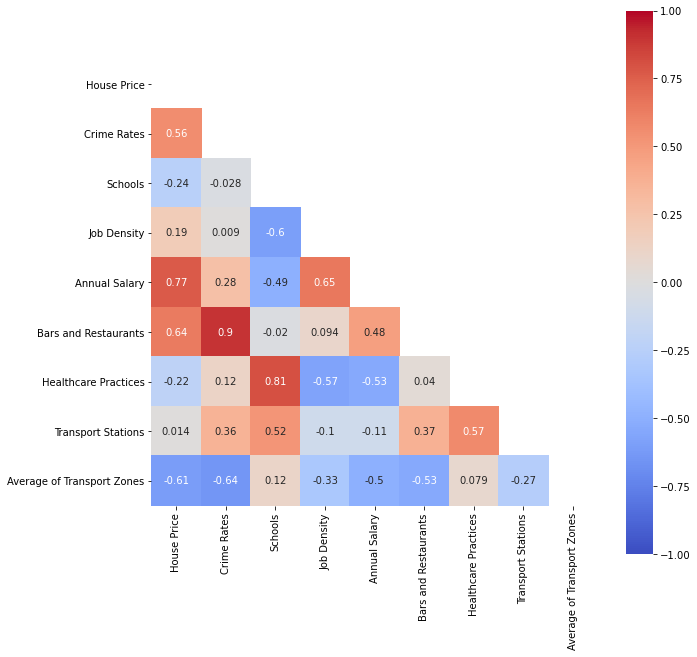

In [31]:
#first we set a size of this correlation matrix so that values are visible 
fig, ax = plt.subplots(figsize=(10,10))

#using the .corr() calculates the correlation matrix 
corr_table_firstyr = (firstyr_dataset.corr())

#using np.triu() can help use get a triangle matrix so that the top half of the duplicated matrix is deleted
matrix = np.triu(firstyr_dataset.corr())

#print Matrix
sn.heatmap(corr_table_firstyr, annot = True, vmin=-1, vmax=1, center= 0, cmap = "coolwarm",square = True, mask = matrix, ax=ax)
plt.show()

We identify that Crime Rate and Bars & Restaurants, are positively correlated with house prices. 

Surprisingly, the number of Schools in a borough decreases, the higher the house price. 

Oddly, the average transport zone variable is negatively correlated with house prices. As zones range from 1 to 6, we gather that more central boroughs closer have higher house prices.

We  observe that the number of Schools in a borough is correlated with the amount of Healthcare Practices(0.81). An increase in Bars & Restaurants is correlated with a higher crime rate (0.9). Individuals living closer towards Central London (Zone 1), tend to have a higher salary (-0.61).

Some of the information may sound intuitive, yet demonstrating the correlations add to the general understanding of how the variables interact.


## Scenario

One particular struggle, when looking for the right house, is finding the ideal area within a suitable range price. However, using the following function helps new home buyers understand  borough traits.

## House Price Finder

To use this function, users must simply input the letter corresponding to their ideal price range. As a result, borough code,  name and prices within the range are presented.


In [32]:
def house_price_finder():
    desired_price=input("""Please indicate your desired house price range: 
    A: £280,000-£380,000.
    B: £380,000-£480,000
    C: £480,000-£750,000.
    D: £750,000-£1,000,000.
    E: more than £1,000,000.
    """) # Ask for customers' input as a letter option.
    # in case customers enter lower-case letter.
    desired_price=desired_price.upper()
    # Below are the five scenarios and their output as a data frame
    if desired_price=="A":
        print ("These are the suitable boroughs.")
        return lastyr_dataset.loc[lastyr_dataset["House Price"].between(280000,380000),["Code","Area","House Price"]]
    elif desired_price=="B":
        print ("These are the suitable boroughs.")
        return lastyr_dataset.loc[lastyr_dataset["House Price"].between(380000,480000),["Code","Area","House Price"]]
    elif desired_price=="C":
        print ("These are the suitable boroughs.")
        return lastyr_dataset.loc[lastyr_dataset["House Price"].between(480000,750000),["Code","Area","House Price"]]
    elif desired_price=="D":
        print ("These are the suitable boroughs.")
        return lastyr_dataset.loc[lastyr_dataset["House Price"].between(750000,1000000),["Code","Area","House Price"]]
    elif desired_price=="E":
        print ("These are the suitable boroughs.")
        return lastyr_dataset.loc[lastyr_dataset["House Price"].between(1000000,1500000),["Code","Area","House Price"]]
    else: # if customers enter other letters or words
        print("Please enter a valid option.")

house_price_finder()  # run the function

Please indicate your desired house price range: 
    A: £280,000-£380,000.
    B: £380,000-£480,000
    C: £480,000-£750,000.
    D: £750,000-£1,000,000.
    E: more than £1,000,000.
    A
These are the suitable boroughs.


,Code,Area,House Price
1,E09000002,BARKING AND DAGENHAM,287734
3,E09000004,BEXLEY,335694
7,E09000008,CROYDON,372554
15,E09000016,HAVERING,360479
24,E09000025,NEWHAM,362131
28,E09000029,SUTTON,376924


From this list of house prices, users can choose their ideal orough and proceed.

## Borough Information Finder

Having narrowed it down to boroughs of interest, we take a closer look by entering the corresponding borough code illustrated above.


In [33]:
def borough_information_finder():
    prompt = input("Please Enter Borough Name: ") #asking for user's input
    prompt=prompt.upper() # Change all input to upper case letter, because the area in final-year dataset are all in capital letter
    # Change the area name into lower case letter and check if the input is in.
    if prompt in str(lastyr_dataset["Area"]): 
        # return the borough as a transposed data frame so it is easier for customer to view
        return lastyr_dataset.loc[lastyr_dataset["Area"]==prompt].T
    else: # If customers enter other letters or words
        print ("Please enter a valid area name from the house price finder.")
borough_information_finder()

Please Enter Borough Name: city of london


,0
Code,E09000001
Area,CITY OF LONDON
House Price,849790
Crime Rates,92.2
Schools,5
Job Density,124.78
Annual Salary,57328.1
Bars and Restaurants,455
Healthcare Practices,2
Transport Stations,13


As a result, users may use the customized table to check whether the borough satisfies their requirements.

Now that our users established the key attributes their dream borough should have, they want to know more about future prices in the area and which attributes are the most important in determining that price. Let us have a look. 


# 4. Predictive Analysis

## Regression Analysis

Pooled-OLS model, one-way fixed-effect model (with entity-effect) and two-way fixed effects model (with both entity and time effects) are generated for our dataset. The dependent variable of the regression model is house price, and the independent variables are all time-variant variables.

Since house prices take large values, a log dependent variable is created. We will use both house price and log house price as dependent variable for each model. Hence, six models will be generated. 


In [34]:
#  Set code and year as index, prepared for regression analysis
regression_df=final_dataset.set_index(["Code","Year"])

#log(House Price) is created
regression_df["log_HousePrice"]=np.log(regression_df["House Price"])
regression_df.head()

# Prepare Independent Variables for convenience and add a constant
x=regression_df[["Schools","Bars and Restaurants","Crime Rates","Job Density","Annual Salary"]]
x=sm.add_constant(x)

Area  House Price  Crime Rates  Schools  \
Code      Year                                                      
E09000001 2011  CITY OF LONDON       463930         90.6        5   
          2012  CITY OF LONDON       525327         85.8        5   
          2013  CITY OF LONDON       570008         77.9        5   
          2014  CITY OF LONDON       709385         85.5        5   
          2015  CITY OF LONDON       760253         82.4        5   

                Job Density  Annual Salary  Bars and Restaurants  \
Code      Year                                                     
E09000001 2011        75.79   52358.800000                 365.0   
          2012        92.41   52379.993605                 370.0   
          2013       110.98   55510.309047                 385.0   
          2014       121.23   55514.808380                 415.0   
          2015       121.73   55889.369644                 420.0   

                log_HousePrice  
Code      Year                  
E09000001 2011       13.047489  
          2012       13.171776  
          2013       13.253406  
          2014       13.472154  
          2015       13.541407

In [35]:
# 1 Pooled OLS
  # 1.1 linear OLS
OLS_1 = PooledOLS(regression_df["House Price"], x)
OLS_linear=OLS_1.fit()
  # 1.2 log-lin OLS
OLS_2 = PooledOLS(regression_df["log_HousePrice"], x)
OLS_log=OLS_2.fit()

# 2 Area-FE model (include only entity effect)
  # 2.1 Linear Area-FE
FE_area1 = PanelOLS(regression_df["House Price"],x,entity_effects=True,time_effects=False)
FE_area_linear = FE_area1.fit(cov_type="robust")
  # 2.2 log Area-FE
FE_area2 = PanelOLS(regression_df["log_HousePrice"],x,entity_effects=True,time_effects=False)
FE_area_log = FE_area2.fit(cov_type="robust")

# 3 Two way fixed effects
 # 3.1 Linear Version
FE2_1 = PanelOLS(regression_df["House Price"],x,entity_effects=True,time_effects=True)
FE_2way_linear = FE2_1.fit(cov_type="robust")
 #3.2 Log version FE-two way
FE2_1 = PanelOLS(regression_df["log_HousePrice"],x,entity_effects=True,time_effects=True)
FE_2way_log = FE2_1.fit(cov_type="robust")

In [36]:
# linear model comparision
print(compare({'OLS-linear':OLS_linear,'FE-oneway':FE_area_linear,'FE-twoway':FE_2way_linear}))

                            Model Comparison                            
                              OLS-linear       FE-oneway       FE-twoway
------------------------------------------------------------------------
Dep. Variable                House Price     House Price     House Price
Estimator                      PooledOLS        PanelOLS        PanelOLS
No. Observations                     231             231             231
Cov. Est.                     Unadjusted          Robust          Robust
R-squared                         0.6439          0.7169          0.4448
R-Squared (Within)                0.1612          0.7169          0.3235
R-Squared (Between)               0.7303         -0.5251          0.0461
R-Squared (Overall)               0.6439         -0.3364          0.0883
F-statistic                       81.353          97.747          29.962
P-value (F-stat)                  0.0000          0.0000          0.0000
======================     =============   ========

In [37]:
# log-lin model comparision
print(compare({'OLS-log':OLS_log,'FE-oneway-log':FE_area_log,'FE-twoway-log':FE_2way_log}))

                                 Model Comparison                                
                                    OLS-log      FE-oneway-log      FE-twoway-log
---------------------------------------------------------------------------------
Dep. Variable                log_HousePrice     log_HousePrice     log_HousePrice
Estimator                         PooledOLS           PanelOLS           PanelOLS
No. Observations                        231                231                231
Cov. Est.                        Unadjusted             Robust             Robust
R-squared                            0.6533             0.6334             0.0386
R-Squared (Within)                   0.3410             0.6334            -0.0129
R-Squared (Between)                  0.7365            -1.0353             0.1065
R-Squared (Overall)                  0.6533            -0.6839             0.0814
F-statistic                          84.778             66.682             1.5011
P-value (F-stat)

The first table shows the linear function form models, while the second table shows the log-log models. It does not become clear  which dependent variable we shall use, as most of them are statistically significant with similar R2. A Pearson’s coefficient is calculated to check the skewness of the house price.

In [38]:
# calculate Pearson’s coefficient for House price, to determine if we should use the log-version or not
house_price_skewness=regression_df["House Price"].describe().astype(int)
Persons_coefficient=3*(house_price_skewness["mean"]+house_price_skewness["50%"])/house_price_skewness["std"]
Persons_coefficient 

11.465027368658653

Results suggest "House Price" is positively skewed. We shall use the log dependent variable. FE-twoway-log has an insignificant F-value, implying the model is insignificant overall, potentially because OLS contains insignificant variables.

Our best model is the one-way FE.

In [39]:
print(FE_area_log)

                          PanelOLS Estimation Summary                           
Dep. Variable:         log_HousePrice   R-squared:                        0.6334
Estimator:                   PanelOLS   R-squared (Between):             -1.0353
No. Observations:                 231   R-squared (Within):               0.6334
Date:                Mon, Dec 14 2020   R-squared (Overall):             -0.6839
Time:                        23:37:24   Log-likelihood                    170.70
Cov. Estimator:                Robust                                           
                                        F-statistic:                      66.682
Entities:                          33   P-value                           0.0000
Avg Obs:                       7.0000   Distribution:                   F(5,193)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             101.41
                            

This model captures 63.34% of the dependent variable's variation.

If number of schools and number of leisure places increases by 1, house prices increase by 1.98% and 0.14% respectively. If crime rates (%) increase by 1%, house prices decrease by 0.46%. A 1 unit increase in job density (job availability/population), results in a 0.47% increase in prices. If a borough's average annual salary increases by £1,000, the borough's house prices increase by 5.009%.

The coefficients are statistically significant and signs are consistent with expectations and economic theories. The magnitude of change shows that annual salary (in £1,000) is the most important factor influencing house price.

## Machine Learning Analysis

We would now like to use some our data to train and test the following models:
1. XGBoost
2. LightGBM
3. Random forest


By comparing the models we hope to find the model making the most accurate predictions.
When training the model, we assign and modify the parameters of various models repeatedly to achieve greater accuracy,
Overall, we aim to derive the following results: 
A comparison of all feature importance diagrams including a ranking on the average of importance in predicting house prices
Three trained models including descriptive information (r2_score, mean_absolute_error, mean_squared_error).
An overall comparison of different models and their respective outcomes.
House price predictions
 


In [40]:
# read the final dataset and drop the 'Area' and 'Code' columns because it is 'string' data
Final_dataset_df = pd.DataFrame(final_dataset)
Final_dataset_df.drop(['Area','Code'],axis = 1,inplace = True)
# show the first five rows to check results we get. 
Final_dataset_df.head()

,Year,House Price,Crime Rates,Schools,Job Density,Annual Salary,Bars and Restaurants
0,2011,463930,90.6,5,75.79,52358.800000,365.0
1,2012,525327,85.8,5,92.41,52379.993605,370.0
2,2013,570008,77.9,5,110.98,55510.309047,385.0
3,2014,709385,85.5,5,121.23,55514.808380,415.0
4,2015,760253,82.4,5,121.73,55889.369644,420.0


### Retrieve Variable Importance ###

Now, we randomly assign our data to two parts, a training and a testing dataset, using train_test_split. We exclude 'House Price' in the train set, while the target set includes  'House Price'.

In [41]:
train_fe = Final_dataset_df.copy() 
target_fe = train_fe['House Price']
del train_fe['House Price']
train_fe.head()
X = train_fe
z = target_fe

# in train_test_split function, first parameter is your train dataset, the second one is your target dataset.
# test_size means the proportion of test dataset
# random_state is a random seed to ensure we can get the same dataset by spliting.
Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state=0)

# lgb.Dataset() is to specific feature names and categorical features:
# Note: we should convert your categorical features to 'int' type before we construct Dataset.

train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

,Year,Crime Rates,Schools,Job Density,Annual Salary,Bars and Restaurants
0,2011,90.6,5,75.79,52358.800000,365.0
1,2012,85.8,5,92.41,52379.993605,370.0
2,2013,77.9,5,110.98,55510.309047,385.0
3,2014,85.5,5,121.23,55514.808380,415.0
4,2015,82.4,5,121.73,55889.369644,420.0


Next, we will use LightGBM to get the importance of each variable for our House Price. LightGBM is a gradient boosting framework that uses tree based learning algorithms, greatly reducing the time complexity of processing samples, without losing accuracy.

Parameters retrieved here: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html

In [42]:
%%capture 
# hide the process of running because there will be too wordy and lengthy if we show it.
params = {
        'boosting_type':'gbdt',  # Gradient Boosting Decision Tree
        'objective': 'regression',# regression , if we want to make classification we need to use 'binary'
        'num_leaves': 31, # number of leaves for one tree
        'learning_rate': 0.05, # learning rate in machine learning, like a speed!
        'max_depth': -1, # default to '-1' which means that we do not limit its depth, the greater the depth, the possible overfitting
        'subsample': 0.8, # sample size
        'bagging_fraction' : 1, # if our data is small, 1 will be better!
        'max_bin' : 5000 , #Feature maximum segmentation
        'bagging_freq': 20, # it is default to '0',It means bagging once every 20 iterations
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1, # Minimum sum of hessians in one leaf to allow a split. Higher values potentially decrease overfitting
        'min_child_samples': 10,#Setting it larger can avoid generating a tree that is too deep, but it may cause underfitting
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,        
    }

modelL = lgb.train(params, train_set = train_set, num_boost_round=1000,
                   early_stopping_rounds=50,verbose_eval=100, valid_sets=valid_set)

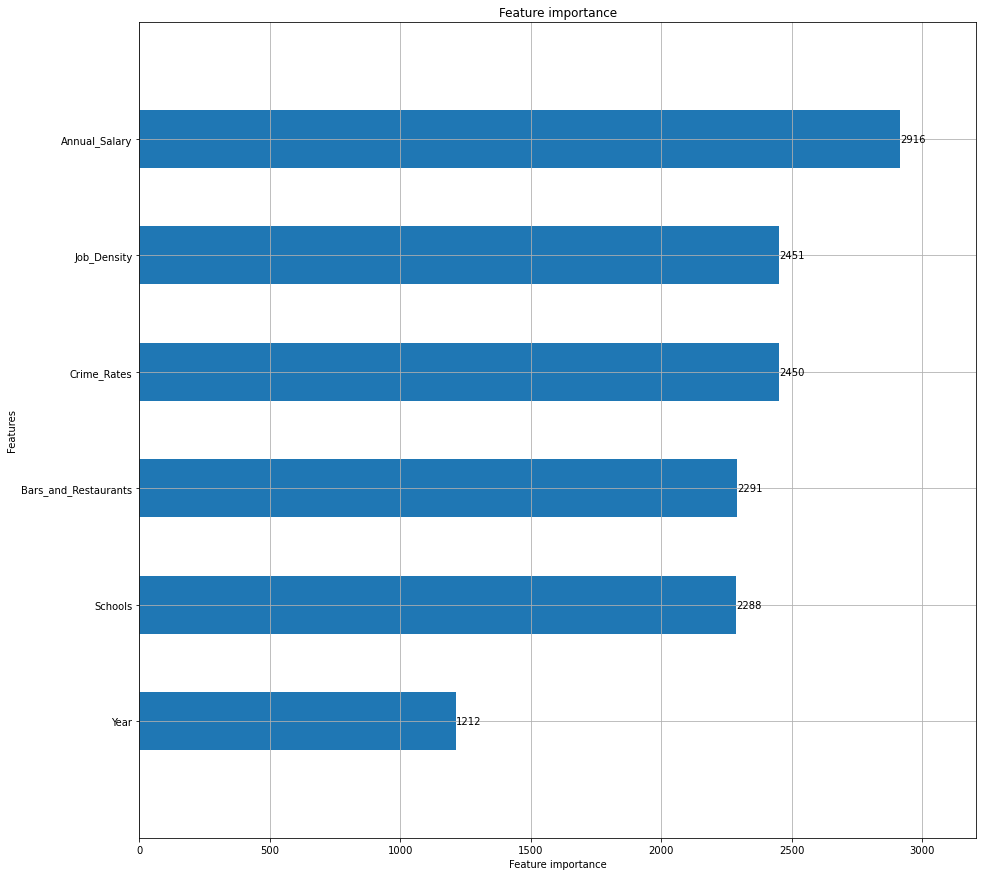

In [43]:
# use matplotlib and plot with lgb to show their importance by bar chart.
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();plt.close()

The graph above implies, according to the LightGBM model, annual salary is the most important varibale in determining House Price, while 'Year' and 'Bars and Restaurants' are least important.

In [44]:
# create a dataframe to save our outcome in one column named 'score_lgb'.
feature_score = pd.DataFrame(train_fe.columns, columns = ['feature']) 
feature_score['score_lgb'] = modelL.feature_importance()

XGBoost is an implementation of the Gradient Boosting Decision Tree (GBDT). 

Continuously add trees, and perform feature splitting to grow our tree. Each time we add a tree, we are actually learning a new function f(x) to fit the residual of the last prediction. Once finished, we must predict the score of a sample. 

In fact, according to the characteristics of this sample, each tree will fall to a 
corresponding leaf node, which corresponds to a score.

In the end, we add up the scores corresponding to each tree to retrieve the predicted value of the sample.

Parameters retrieved here: https://xgboost.readthedocs.io/en/latest/python/index.html

In [45]:
# split training set to validation set 
# assgin our data to the xgb matirx because xgboost requrie the input is a matrix type.
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xval , label=Zval)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [46]:
%%capture
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:squarederror', # regression type
         'eta'      :0.3,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :4, #L2 regularization term,>1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10}
modelx = xgb.train(parms, data_tr, num_boost_round=200, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=10)

print('score = %1.5f, n_boost_round =%d.'%(modelx.best_score,modelx.best_iteration))

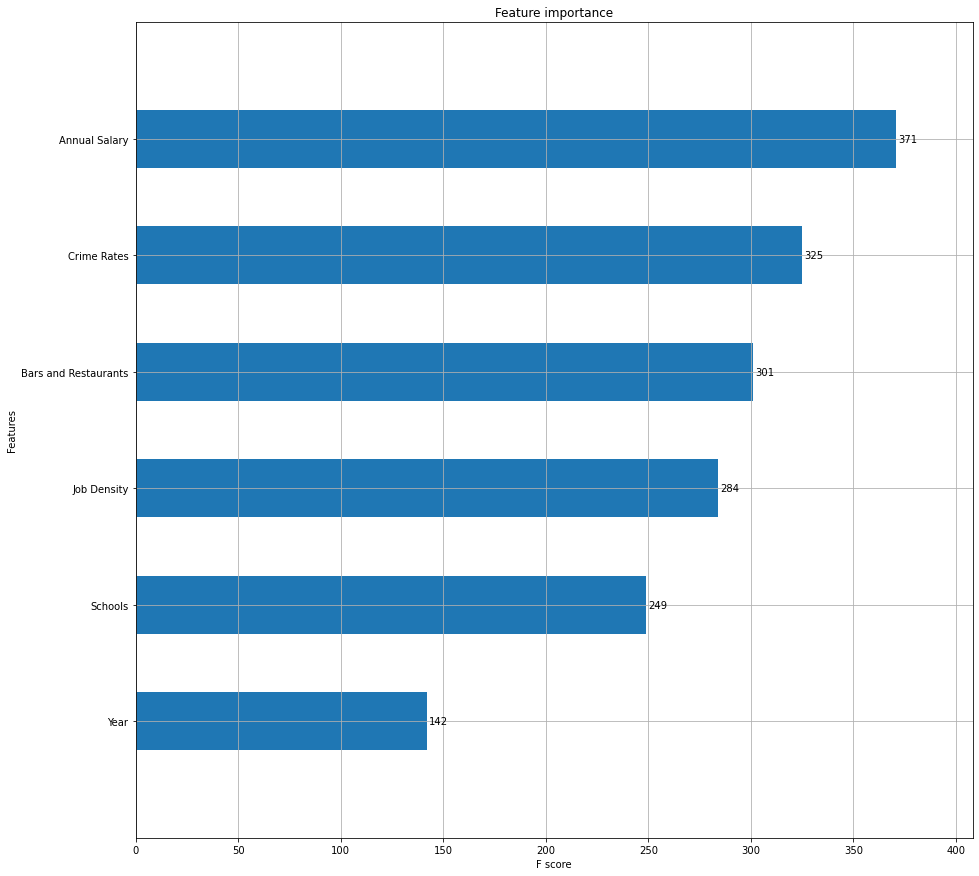

In [47]:
# use matplotlib and plot with xgb to show their importance by bar chart.
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(modelx,ax = axes,height = 0.5)
plt.show();plt.close()

The graph illustrates that annually salary remains the most important variable, while ‘Schools’ has lost in importance. Additionally, the importance of 'Job Density' and 'Bars and Restaurants' increased greatly due to the different gradient method in different models.

In [48]:
# create a dataframe to save our outcome in one column named 'score_xgb'.
feature_score['score_xgb'] = feature_score['feature'].map(modelx.get_score(importance_type='weight'))

Next, we will run a logistic regression, analysing the variables’ coefficients to derive importance. However,  we must retrieve  results after standardizing, due to the variables differing scales.

In [49]:
# Standardization for regression model and generate a dataframe for our logistic regression 
train_fe = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(train_fe),
    columns=train_fe.columns,
    index=train_fe.index)



In [50]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(train_fe, target_fe)
coeff_logreg = pd.DataFrame(train_fe.columns.delete(0))
coeff_logreg.columns = ['feature']
coeff_logreg["score_logreg"] = pd.Series(logreg.coef_[0])
coeff_logreg.sort_values(by='score_logreg', ascending=False)

LogisticRegression()

,feature,score_logreg
1,Schools,0.058646
3,Annual Salary,-0.026421
2,Job Density,-0.214256
4,Bars and Restaurants,-0.228347
0,Crime Rates,-0.447357


In [51]:
# the level of importance of features is not associated with the sign
# create a dataframe to save our outcome in one column named 'score_logreg'.
coeff_logreg["score_logreg"] = coeff_logreg["score_logreg"].abs()
feature_score = pd.merge(feature_score, coeff_logreg, on='feature')

Lastly, we run a linear regression, using 'preprocessing.MinMaxScaler().fit_transform' to transform the variables’ scale with different weights to (0,1).

In [52]:
# Linear Regression
linreg = LinearRegression()
linreg.fit(train_fe, target_fe) #fit the regression model
coeff_linreg = pd.DataFrame(train_fe.columns.delete(0))
coeff_linreg.columns = ['feature'] # change the column name
coeff_linreg["score_linreg"] = pd.Series(linreg.coef_)
coeff_linreg.sort_values(by='score_linreg', ascending=False)

LinearRegression()

,feature,score_linreg
4,Bars and Restaurants,1.013117e+06
1,Schools,6.123616e+05
0,Crime Rates,2.319551e+05
2,Job Density,-4.870303e+04
3,Annual Salary,-5.571588e+05


In [53]:
# To compare the different models, we merge the outcomes row by row.
# The level of importance of features is not associated with the sign
# Create a dataframe to save our outcome in one column named 'score_linreg'.
coeff_linreg["score_linreg"] = coeff_linreg["score_linreg"].abs()

# merge those 4 columns to a new dataframe named feature_score
feature_score = pd.merge(feature_score, coeff_linreg, on='feature')
feature_score = feature_score.fillna(0)
feature_score = feature_score.set_index('feature')
feature_score

,score_lgb,score_xgb,score_logreg,score_linreg
feature,,,,
Crime Rates,2450,325,0.447357,2.319551e+05
Schools,2288,249,0.058646,6.123616e+05
Job Density,2451,284,0.214256,4.870303e+04
Annual Salary,2916,371,0.026421,5.571588e+05
Bars and Restaurants,2291,301,0.228347,1.013117e+06


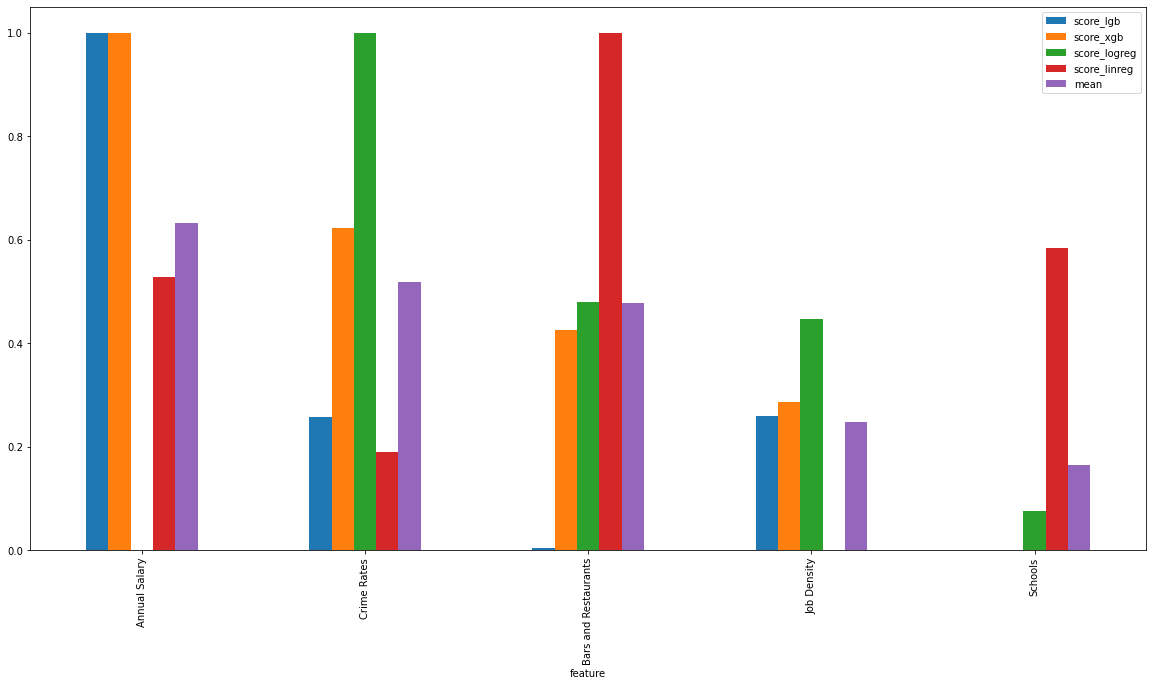

In [54]:

# use matplotlib to plot their importance variable by variable in bar chat.
feature_score = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(feature_score),
    columns=feature_score.columns,
    index=feature_score.index
)

# Create mean column
feature_score['mean'] = feature_score.mean(axis=1)

# Plot the feature importances
feature_score.sort_values('mean', ascending=False).plot(kind='bar', figsize=(20, 10))

In [55]:
# sort them by the means of importance
feature_score.sort_values('mean', ascending=False)

,score_lgb,score_xgb,score_logreg,score_linreg,mean
feature,,,,,
Annual Salary,1.000000,1.000000,0.000000,0.527217,0.631804
Crime Rates,0.257962,0.622951,1.000000,0.190014,0.517732
Bars and Restaurants,0.004777,0.426230,0.479708,1.000000,0.477679
Job Density,0.259554,0.286885,0.446233,0.000000,0.248168
Schools,0.000000,0.000000,0.076556,0.584457,0.165253


 The illustration above shows the impact of each variable on House Price ranked by 'mean'. Annual salary consistently ranks as greatest influencer of house prices, while number of Bars or Restaurants hold the weakest influence. 

### Train and Test our Model###

Next, we use three models for training and testing: 
1. Random Forest: Training the model and checking the accuracy ratee.
2. XGboost: Training our dataset with XGBoost model, returning its score and rmse. 
3. LightGBM: Lastly, we importing LightGBM model and report its outcome.

In [56]:
target_name = 'House Price'
train_target0 = Final_dataset_df[target_name]
train0 = Final_dataset_df.drop([target_name], axis=1)

In [57]:
# Synthesis test0 from train0
train0, test0, train_target0, test_target0 = train_test_split(
    train0, train_target0, test_size=0.2, random_state=0)

In [58]:
# For boosting model
train0b = train0
train_target0b = train_target0
# Synthesis valid as test for selection models
trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size=0.3, random_state=0)

In [59]:
#For models from Sklearn, data normalization and standardization
scaler = StandardScaler()
train0 = pd.DataFrame(scaler.fit_transform(train0), columns = train0.columns)

In [60]:
# Synthesis test0 from train0
train0, test0, train_target0, test_target0 = train_test_split(
    train0, train_target0, test_size=0.2, random_state=0)

In [61]:
# For boosting model
train0b = train0
train_target0b = train_target0
# Synthesis valid as test for selection models
trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size=0.3, random_state=0)

In [62]:
#For models from Sklearn, data normalization and standardization
scaler = StandardScaler()
train0 = pd.DataFrame(scaler.fit_transform(train0), columns = train0.columns)

In [63]:
# Synthesis valid as test for selection models
train, test, target, target_test = train_test_split(train0, train_target0, test_size=0.3, random_state=0)

To calculate the r2 and rmse of each model, we must define new functions:

In [64]:
# create four empty list to store the outcome.
acc_train_r2 = []
acc_test_r2 = []
acc_train_rmse = []
acc_test_rmse = []

In [65]:
# RMSE between predicted y_pred and measured y_meas values
def acc_rmse(y_meas, y_pred):
    return (mean_squared_error(y_meas, y_pred))**0.5

In [66]:
# Calculation of accuracy of boosting model by different metrics
def acc_boosting_model(num,model,train,test,num_iteration=0):
    global acc_train_r2, acc_test_r2,acc_train_rmse, acc_test_rmse
    
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', targetb[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(targetb, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_rmse_num = round(acc_rmse(targetb, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_testb[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_testb, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_rmse_num = round(acc_rmse(target_testb, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [67]:
# Calculation of accuracy of model from Sklearn by different metrics
def acc_model(num,model,train,test):
    global acc_train_r2, acc_test_r2,acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

Now, we use random forest to train the model and check its accuracy rate.

In [68]:
random_forest = RandomForestRegressor() # create a randomforest function
random_forest.fit(train, target) # train the model
acc_model(1,random_forest,train,test) # return the outcome by the function we defined

RandomForestRegressor()

target =  [435807 386200 506799 484592 260476]
ytrain =  [404287.98 416220.69 482675.55 468705.57 269181.67]
acc(r2_score) for train = 96.22
acc(rmse) for train = 3630269.8
target_test = [339685 760833 964643 995543 570008]
ytest = [281733.34 599055.65 807129.19 848916.73 773846.1 ]
acc(r2_score) for test = 68.77
acc(rmse) for test = 12350697.68


XGboost: Next, we train our dataset with XGBoost model, returning its score and rmse.

In [69]:
xgb_clf = xgb.XGBRegressor(objective = 'reg:squarederror')  # set our regression type as squarderror
parameters = {'n_estimators': [60, 100, 120, 140], 
              'learning_rate': [0.01, 0.1],
              'max_depth': [5, 7],
              'reg_lambda': [0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(trainb, targetb) # train the model
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_boosting_model(2,xgb_reg,trainb,testb)# print the outcome with the function that we have defined

Best score: 0.634
Best parameters set: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 60, 'reg_lambda': 0.5}
target =  [435807 386200 506799 484592 260476]
ytrain =  [426647.7  391055.7  499246.7  478518.25 260945.62]
acc(r2_score) for train = 99.8
acc(rmse) for train = 840657.73
target_test = [339685 760833 964643 995543 570008]
ytest = [294219.62 642578.5  793559.44 794539.06 691809.4 ]
acc(r2_score) for test = 67.81
acc(rmse) for test = 12539875.87


In [70]:
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=0.2, random_state=0)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

In [71]:
%%capture 
# hide the process of running because there will be too wordy and lengthy if we show it.
# adjusting the parameter of lgb to make it more proper
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': False,
        'seed':0,        
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000,
                   early_stopping_rounds=50,verbose_eval=10, valid_sets=valid_set)
# train the lightgbm model again for better result

In [72]:
acc_boosting_model(3,modelL,trainb,testb,modelL.best_iteration) # return the score and rmse.

target =  [435807 386200 506799 484592 260476]
ytrain =  [385530.92304794 398470.15594588 476353.19240978 447017.2865607
 320626.91197774]
acc(r2_score) for train = 74.22
acc(rmse) for train = 9477831.12
target_test = [339685 760833 964643 995543 570008]
ytest = [300064.63911308 500472.0031412  734720.37246198 735886.96038568
 702907.46033295]
acc(r2_score) for test = 60.51
acc(rmse) for test = 13889036.42


In [73]:
# generate a dataframe that we can compare the scroe and rmse
models = pd.DataFrame({
    'Model': ['Random Forest', 'XGB', 'LGBM'],
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [74]:
pd.options.display.float_format = '{:,.2f}'.format
models

,Model,r2_train,r2_test,rmse_train,rmse_test
0,Random Forest,96.22,68.77,"3,630,269.80","12,350,697.68"
1,XGB,99.80,67.81,"840,657.73","12,539,875.87"
2,LGBM,74.22,60.51,"9,477,831.12","13,889,036.42"


In [75]:
testn = pd.DataFrame(scaler.transform(test0), columns = test0.columns)

In [76]:
lgb_predict = modelL.predict(test0)# predict the house price in the test dataset
final_df = test_target0.values # find the target value
final_df = pd.DataFrame(final_df,columns=['Real_price'])
final_df['predicted_prices'] = lgb_predict.astype(int) # change it type to 'int'
final_df['difference'] = abs(final_df['Real_price'] - final_df['predicted_prices']).astype(int) # change it type to 'int'
final_df.head(20)# show prediction of the first 10 rows.

,Real_price,predicted_prices,difference
0,577055,635447,58392
1,696926,731601,34675
2,314934,351254,36320
3,331124,382673,51549
4,787440,732357,55083
5,642137,587634,54503
6,315812,358908,43096
7,467867,488478,20611
8,424103,441490,17387
9,436116,378441,57675


As LGBM has the highest test score, 85.46,  we select LGBM as our prediction model; although it is not very accurate.

# 5. Limitations

<p style='text-align: justify;'>Our dataset only covers 2011 to 2017, a longer historical time frame can generate more up-to-date results and better predictions. Also, the prediction of house price in the future should consider unforeseen events, such as financial crisis. </p>
    
<p style='text-align: justify;'>As for regression analyses, multicollinearity, shown by the correlation matrix, may bias results. Omitted variables that affect both house price and independent variables -- such as inflation, may further bias the result. Therefore, the regression analysis does not necessarily imply  casual inference between the factors and the house price. Further empirical research is necessary. The accuracy of machine learning analysis can be increased, if with more data points for training and testing.
</p>

# 6. Conclusion

A finder gathering boroughs based on different traits has been developed to aid buyers in their search and to support the government in analysing the state of boroughs and highlighting developments over the years.

Both the regressions and machine learning methods illustrate that average annual salary (in £1,000) is the most important factor affecting house prices. 